In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
import reboundx
import reboundx.constants
import os
def progress(current, total, barLength = 96//4):
    # A simple progress bar
    percent = float(current+1) * 100 / total
    arrow   = '-' * int(percent/100 * barLength - 1) + '>'
    spaces  = ' ' * (barLength - len(arrow))
    print('[%s%s] %.0f%%' % (arrow, spaces, percent), end='\r')

# Open all SimulationArchives

In [2]:
# This function sets up additional non-Newtonian forces used in the original integration
def setup(sim):
    rebx = reboundx.Extras(sim)
    gr = rebx.load_force('gr_potential')
    rebx.add_force(gr)
    gr.params['c'] = reboundx.constants.C    
# Directory where the SimulationArchives are stored
path = "/data_local2/rein/solarsystem/"
sas = []
for f in os.listdir(path):
    # Optimized loading by reusing the SimulationArchive index.
    # This only works because the index is exactly the same.
    # Also note that we're hiding warning message.
    sa = rebound.SimulationArchive(path+f, setup=setup, reuse_index=(sas[0] if sas else None), process_warnings=False)
    sas.append(sa)

In [3]:
Nfiles = len(sas)            # Number of files
Nsnapshots = len(sas[0])     # Number of snapshots in each file
dt = sas[0][1].t-sas[0][0].t # Time between snapshots (code units: year/2pi)
print("Number of files:", Nfiles)
print("Number of snapshots in each file:", Nsnapshots)
print("Sampling interval: %.1f yrs"%(dt/np.pi/2.))

Number of files: 96
Number of snapshots in each file: 500006
Sampling interval: 10000.0 yrs


# Reading in orbital parameters
Let us read 5000 snapshots. This corresponds to only 1% of the number of snapshots available. Depending on your hard drive's speed this may take a couple of minutes. Reduce the number of samples or the number of files to speed it up.

In [4]:
NeccSamples = 5000
time = np.zeros(NeccSamples)
ecc = np.zeros((Nfiles, NeccSamples))
for i in range(Nfiles):
    for j in range(NeccSamples):
        sa = sas[i]
        sim = sa[j*(Nsnapshots//NeccSamples)]
        ecc[i,j] = sim.particles[1].e
        time[j] = sim.t
    progress(i, Nfiles)

# Plot Mercury's eccentricity
Because the eccentricity of Mercury oscillates a lot, we will plot a moving average over 50 million years.

In [5]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

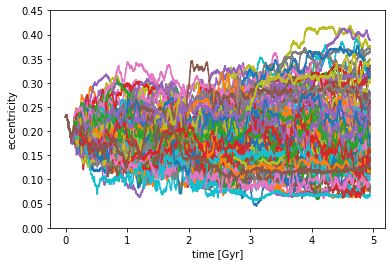

In [6]:
fig, ax = plt.subplots()
ax.set_xlabel("time [Gyr]")
ax.set_ylabel("eccentricity")
ax.set_ylim([0,0.45])
dT = time[1]-time[0] # time between snapshots loaded 
tavg = 50e6 # Average over 50 million years
Navg = int(tavg*np.pi*2.//dT) # Number of samples to average
for i in range(Nfiles):    
    mavg = moving_average(ecc[i],Navg)
    ax.plot(time[:len(mavg)]/np.pi/2./1e9, mavg)
#fig.savefig("eccentricity.pdf")

# Resampling 
We pick one random simulation and plot the eccentricity of Mercury in a 100,000 year interval after 3 billion yeares. Because snapshots are only taken every 10,000 years, there are only 10 samples store in the Simulation archive (plotted as points below). To get a higher sampling rate, we reintegrate the simulation, starting from the closest snapshot. The CPU time required to integrate from one snapshot to the next is about 3s. Integrating between the 10 snapshots will therefore take about 30s. Note that is easy to parallelize this, with each thread starting an integration from one of the 10 snapshots.  

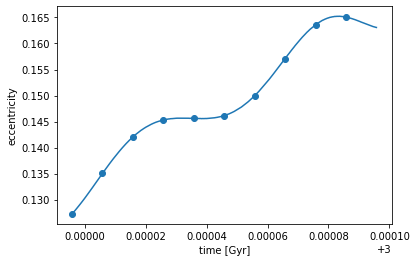

In [8]:
fig, ax = plt.subplots()
#ax.set_xlim([2.9999,3.0021])
ax.set_xlabel("time [Gyr]")
ax.set_ylabel("eccentricity")
sa = sas[7] # random simulation
sim = sa.getSimulation(3e9*np.pi*2, mode="snapshot")

Nfinesmaples = 1000    
time_fine = np.linspace(sim.t,sim.t+1e5*np.pi*2.,Nfinesmaples)
ecc_fine = np.zeros(Nfinesmaples)
for i in range(Nfinesmaples):
    sim.integrate(time_fine[i], exact_finish_time=False)
    # Update time to match actual simulation time
    # (might by offset by a fraction of a timestep)
    time_fine[i] = sim.t 
    ecc_fine[i] = sim.particles[1].e
    progress(i,Nfinesmaples)    
ax.plot(time_fine/np.pi/2./1e9,ecc_fine)


istart = sa._getSnapshotIndex(3e9*np.pi*2)[0]
istop  = sa._getSnapshotIndex(sim.t)[0]
Nsamples = istop-istart
time = np.zeros(Nsamples)
ecc = np.zeros(Nsamples)
for i in range(Nsamples):
    sim = sa[i+istart]
    time[i] = sim.t
    ecc[i] = sim.particles[1].e
ax.scatter(time/np.pi/2./1e9,ecc);

# Exact reproducability
Simulations are exactly reproducible, even taking into account finite floating point precission. This means we can integrate from one snapshot to the next and reproduce the second snapshot exactly, down to the last bit. The following code illustrates this.

In [9]:
sa = sas[5] # random simulation
i = 12345 # random snapshot

# Load snapshot
sim = sa[i+1]
sim.integrator_synchronize()
print("x-position of Mercury: %.20f"%sim.particles[1].x)

# Redo integration
sim = sa[i]
sim.integrate(sim.t+dt,exact_finish_time=False)
sim.integrator_synchronize()
print("x-position of Mercury: %.20f"%sim.particles[1].x)

x-position of Mercury: -0.41996010816939360888
x-position of Mercury: -0.41996010816939360888
